In [1]:
import os, shutil

import xarray as xr
import dask.dataframe as dd

#from rechunker import rechunk
# need version 0.3.3, see: https://github.com/pangeo-data/rechunker/issues/92

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5606496.datarmor0/parcels-502090/libparcels_random_4e47d0cb-e6d3-4bac-9a9d-791c139976b8.so


In [2]:
import pandas as pd
import numpy as np

In [3]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3
                 )
#
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.1.48:36096 Dashboard: http://10.148.1.48:8787/status,Cluster Workers: 21 Cores: 21 Memory: 335.37 GiB


### NWA

In [6]:
# output archives
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "ZC_NWA")
llc_zarr = os.path.join(out_dir, "llc.zarr")

parcels_index= 'time_mean'
parcels_name = "llc_parcels_"+parcels_index
parcels_path = os.path.join(out_dir, parcels_name)


In [7]:
ds = xr.open_zarr(llc_zarr)


In [8]:
ds['zonal_velocity_var'] = (ds['zonal_velocity']-ds['zonal_velocity'].mean('time'))**2
ds['meridional_velocity_var'] = (ds['meridional_velocity']-ds['meridional_velocity'].mean('time'))**2

In [9]:
ds_mean = ds.mean('time').compute()

dfE_mean = ds_mean.drop(['face']).to_dataframe()

In [10]:
import numpy as np
dl = 1.
lonmin,lonmax = dfE_mean.lon.min(),dfE_mean.lon.max()
latmin,latmax = dfE_mean.lat.min(),dfE_mean.lat.max()
lon = np.arange(lonmin,lonmax, dl)
lat = np.arange(latmin, latmax, dl)

In [12]:
import pandas as pd
#df['lon'] = (df['lon']+180)%360 - 180
dfE_mean['lon_cut'] = pd.cut(dfE_mean['lon'], lon)
dfE_mean['lat_cut'] = pd.cut(dfE_mean['lat'], lat)
#df_mean = df_mean.groupby(['lon_cut','lat_cut']).apply(lambda x:x.mean(skipna=False))

In [13]:
df_count = dfE_mean.groupby(['lon_cut','lat_cut']).apply(lambda x:x.count())

In [14]:
df_count = pa.add_geodata(df_count)

In [15]:
df_count = (df_count
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )

In [16]:
df_count = df_count['zonal_velocity'].assign_coords({'lat':np.around(df_count.lat,decimals=1),'lon':np.around(df_count.lon,decimals=1)})

In [17]:
dfE_mean = dfE_mean.groupby(['lon_cut','lat_cut']).apply(lambda x:x.mean(skipna=False))
dfE_mean = pa.add_geodata(dfE_mean)

In [18]:
dfE_mean = (dfE_mean
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
dfE_mean

<xarray.Dataset>
Dimensions:                  (lat: 8, lon: 5)
Coordinates:
  * lon                      (lon) float64 120.5 121.5 122.5 123.5 124.5
  * lat                      (lat) float64 -19.5 -18.5 -17.5 ... -13.5 -12.5
Data variables:
    Depth                    (lon, lat) float64 22.88 79.74 ... 110.4 113.1
    SSU                      (lon, lat) float64 nan 0.006354 ... -0.005 -0.01962
    SSV                      (lon, lat) float64 nan 0.007988 ... 0.006276
    meridional_velocity      (lon, lat) float64 nan 0.007988 ... 0.006276
    zonal_velocity           (lon, lat) float64 nan 0.006354 ... -0.005 -0.01962
    zonal_velocity_var       (lon, lat) float64 nan 0.07955 ... 0.02505 0.02761
    meridional_velocity_var  (lon, lat) float64 nan 0.1273 ... 0.04579 0.05512

In [19]:
dfE_mean = dfE_mean.assign_coords({'lat':np.around(dfE_mean.lat,decimals=1)
                                                     ,'lon':np.around(dfE_mean.lon,decimals=1)})

In [20]:
#dfE_mean = dfE_mean.assign_coords({'lat':np.around(dfE_mean.lat,decimals=1),'lon':np.around(dfE_mean.lon,decimals=1)})
dfE_mean = dfE_mean.where(df_count>2900,drop=False)

In [23]:
#Lagrangian outputs
df = dd.read_parquet(parcels_path)

In [24]:
df = df.drop(columns=['SST_interp','SSS_interp','Eta_interp','salinity','temperature','sea_level']).rename(columns={'SSU_interp':'zonal_velocity_mean','SSV_interp':'meridional_velocity_mean'})
df = pa.degs2ms(df) #Convert in m/s 


df= df.compute()

In [25]:
bbox = [120, 126, -20, -10] # North-west Australia

dl = 1.
lonmin,lonmax = bbox[0],bbox[1]#df.lon.values.max()
latmin,latmax = bbox[2],bbox[3]#df.lat.values.min(),df.lat.values.max()
lon = np.arange(lonmin,lonmax, dl)
lat = np.arange(latmin, latmax, dl)
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = pd.cut(df['lon'], lon)
df['lat_cut'] = pd.cut(df['lat'], lat)

In [26]:
df_reset = df.reset_index()
group = ['lon_cut','lat_cut']
df_mean = df_reset.drop(columns=['trajectory','z','lat','lon']
                  ).groupby(group).agg(lambda x: x.mean(skipna=False))

In [27]:
# Rename columns for mean velocity fields and merge binned fields with original dataframe
df_mean = df_mean.rename(columns={V:V+'_binned' for V in df_mean.columns})

df_merged = (df_reset
             .merge(df_mean.reset_index(), on=["lon_cut", "lat_cut"])
            )
df_merged

,time,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,zonal_velocity_mean,meridional_velocity_mean,lon_cut,lat_cut,time_binned,zonal_velocity_binned,meridional_velocity_binned,zonal_velocity_mean_binned,meridional_velocity_mean_binned
0,2011-11-15 00:00:00,25000223,-19.150501,120.593750,0.0,0.000000,0.000000,0.014085,0.004799,"(120.0, 121.0]","(-20.0, -19.0]",2012-05-18 20:50:07.518557184,0.016025,-0.028053,NaN,NaN
1,2011-11-15 01:00:00,25000223,-19.165975,120.609971,0.0,0.539531,-0.568472,0.014761,0.003217,"(120.0, 121.0]","(-20.0, -19.0]",2012-05-18 20:50:07.518557184,0.016025,-0.028053,NaN,NaN
2,2011-11-15 02:00:00,25000223,-19.173854,120.620276,0.0,0.406756,-0.388483,0.011687,0.001116,"(120.0, 121.0]","(-20.0, -19.0]",2012-05-18 20:50:07.518557184,0.016025,-0.028053,NaN,NaN
3,2011-11-15 03:00:00,25000223,-19.172406,120.622795,0.0,0.191330,-0.104056,0.010740,0.000732,"(120.0, 121.0]","(-20.0, -19.0]",2012-05-18 20:50:07.518557184,0.016025,-0.028053,NaN,NaN
4,2011-11-15 04:00:00,25000223,-19.162503,120.618123,0.0,-0.044672,0.193931,0.012421,0.001860,"(120.0, 121.0]","(-20.0, -19.0]",2012-05-18 20:50:07.518557184,0.016025,-0.028053,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405449,2012-11-08 23:00:00,25000240,-19.526023,121.055983,0.0,-0.062965,0.010669,NaN,NaN,"(121.0, 122.0]","(-20.0, -19.0]",2012-05-01 03:46:44.802744576,0.005549,-0.035901,NaN,NaN
405450,2012-11-09 00:00:00,25000189,-19.209339,121.064404,0.0,-0.135228,0.109854,0.000536,-0.017181,"(121.0, 122.0]","(-20.0, -19.0]",2012-05-01 03:46:44.802744576,0.005549,-0.035901,NaN,NaN
405451,2012-11-09 00:00:00,25000240,-19.525050,121.054411,0.0,-0.058569,0.027341,NaN,NaN,"(121.0, 122.0]","(-20.0, -19.0]",2012-05-01 03:46:44.802744576,0.005549,-0.035901,NaN,NaN
405452,2012-11-09 01:00:00,25000189,-19.206847,121.060520,0.0,-0.131504,0.098400,-0.000235,-0.017375,"(121.0, 122.0]","(-20.0, -19.0]",2012-05-01 03:46:44.802744576,0.005549,-0.035901,NaN,NaN


In [28]:
# Set time as index
df_merged = df_merged.set_index('time')

In [29]:
for V in ['zonal_velocity','meridional_velocity']:
    df_merged[V+'_var_ibinned'] = (df_merged[V]-df_merged[V+'_mean_binned'])**2
    df_merged[V+'_var_binned'] = (df_merged[V]-df_merged[V+'_binned'])**2
    df_merged[V+'_var_itime'] = (df_merged[V]-df_merged[V+'_mean'])**2
    df_merged[V+'_square'] = df_merged[V]**2
    df_merged[V+'_mean_square'] = df_merged[V+'_mean']**2

In [30]:
dfL_mean = df_merged.groupby(['lon_cut','lat_cut']).agg(lambda x: x.mean(skipna=False))

In [31]:
dfL_mean = pa.add_geodata(dfL_mean)
dfL_mean = (dfL_mean
          .set_index(['lon', 'lat'])
         .to_xarray()
        )

In [32]:
dfL_mean = dfL_mean.where(df_count>2900,drop=False)

### Visualization

In [33]:
tracks = ut.load_swot_tracks()

In [34]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
def plot_site(bbox,k,colmap='RdBu_r',figsize=(5,5)):

    central_lon = (bbox[0]+bbox[1])*0.5
    central_lat = (bbox[2]+bbox[3])*0.5

    polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
    gdf = tracks["swath"]
    gdf_clipped = gpd.clip(gdf, polygon)

    #crs = ccrs.Orthographic(central_lon, central_lat)
    crs = ccrs.AlbersEqualArea(central_lon, central_lat)

    crs_proj4 = crs.proj4_init

    fig, ax = plt.subplots(1, k, 
                           subplot_kw={'projection': crs},
                           figsize=figsize,
                          )
    #ds_Lstats[V].plot(ax=ax,transform=ccrs.PlateCarree(),y='lat',vmax=vmax,cmap=colmap)
#    ax.set_extent(bbox)

    #_gdf = gdf.cx[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    _gdf = gdf_clipped
    gdf_crs = _gdf.to_crs(crs_proj4)
    for a in ax:
        a.add_geometries(gdf_crs['geometry'],
                          crs=crs,
                          facecolor='grey', 
                          edgecolor='black',
                          alpha=0.5,
                         )

        a.gridlines(draw_labels=True)
    #    ax.coastlines(resolution='50m')
        a.set_extent(bbox)
    return fig, ax

In [35]:
def plot_swot(df,col,bbox,k,vmax,colmap,figsize):
    fig,ax = plot_site(bbox,k,figsize=figsize)
    if k!=1:
        for V,c,a in zip(df,col,ax):
            V.plot.scatter(ax=a,transform=ccrs.PlateCarree(),x='lon',y='lat',c=c,s=5,cmap=colmap,vmax=vmax)
    else:
        df.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat',c=col,s=5,cmap=colmap,vmax=vmax)
    fig.tight_layout()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


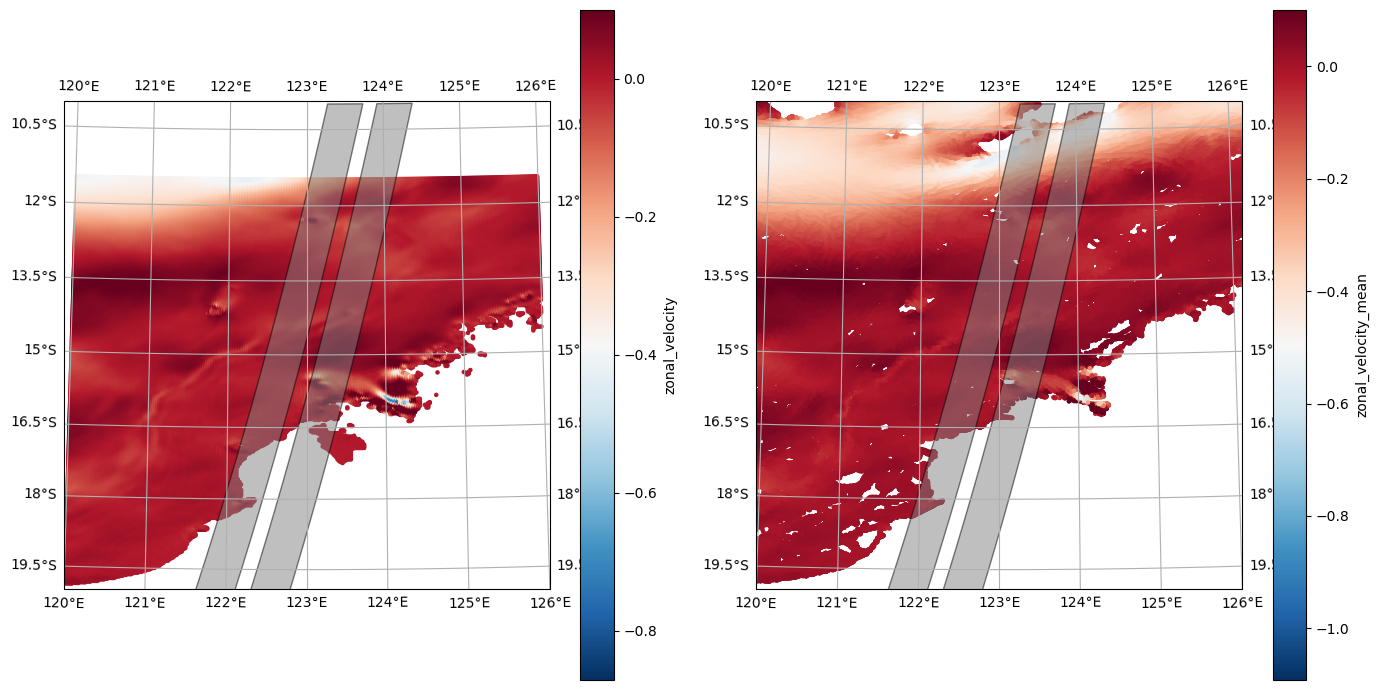

In [36]:
import geopandas as gdp
colmap='RdBu_r'
plot_swot([ds_mean.drop(['face']).to_dataframe(),df],['zonal_velocity','zonal_velocity_mean'],bbox,2,0.1,colmap,(14,7))

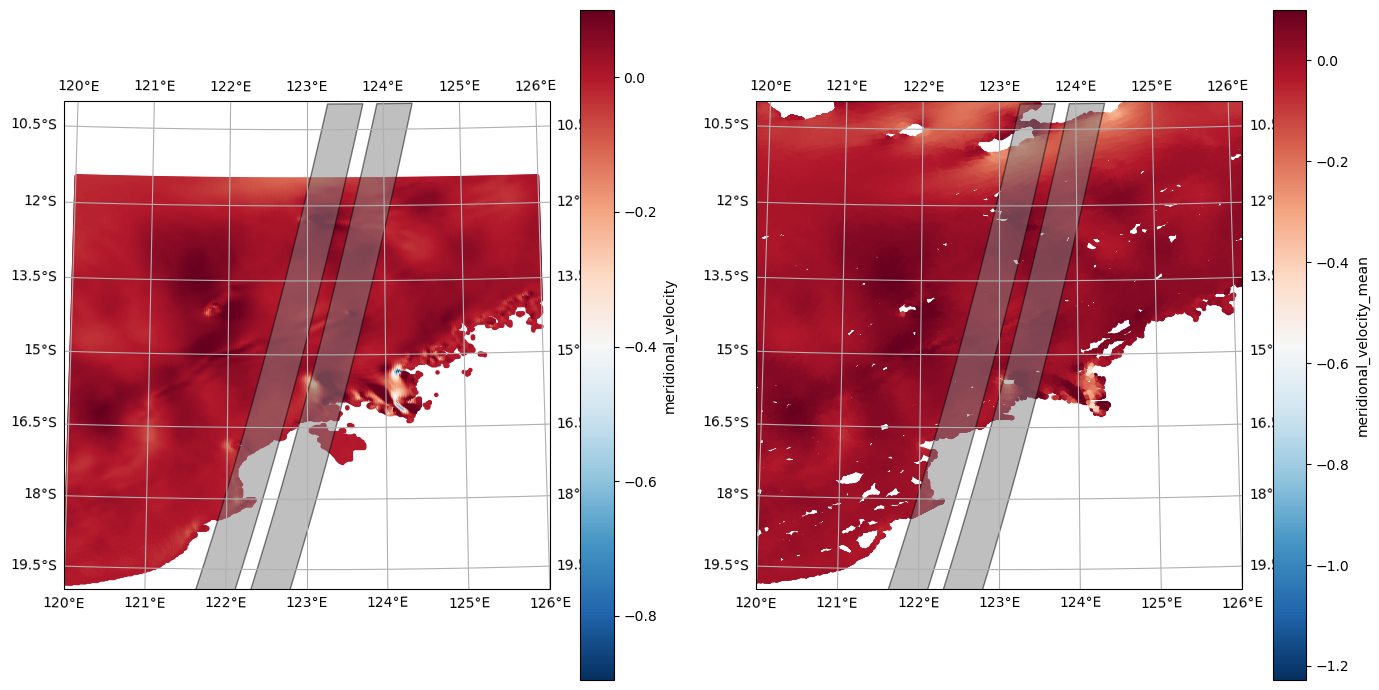

In [37]:
plot_swot([ds_mean.drop(['face']).to_dataframe(),df],['meridional_velocity','meridional_velocity_mean'],bbox,2,0.1,colmap,(14,7))

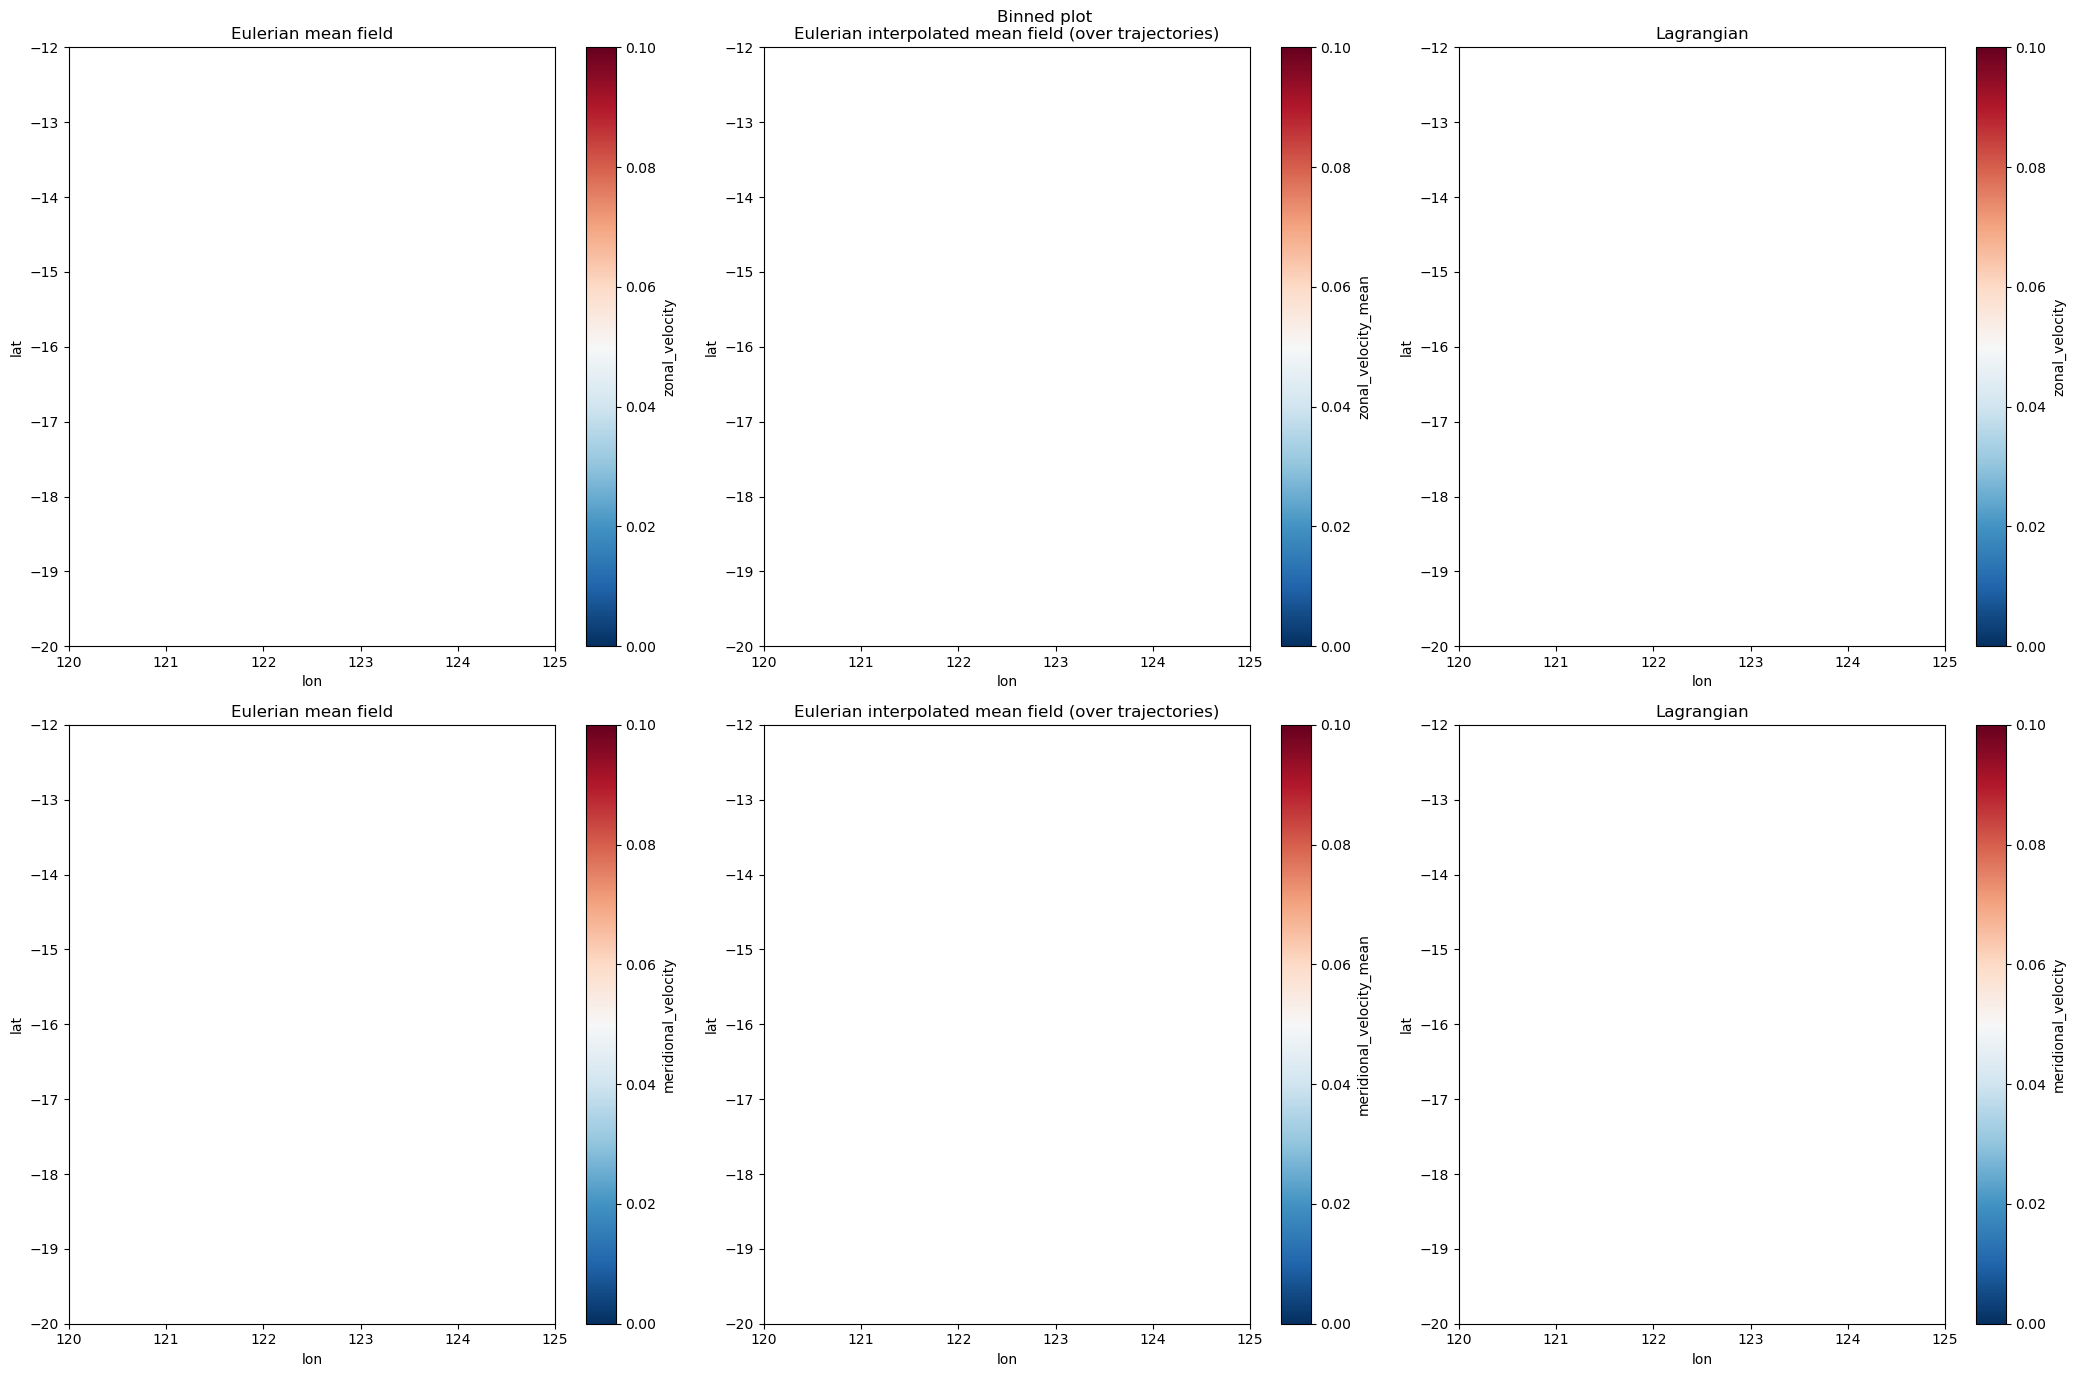

In [38]:
vmax=0.1
fig, axs = plt.subplots(2, 3, 
                           figsize=(21,14),
                          )
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    dfE_mean[V].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,0],vmax=vmax)
    dfL_mean[V+'_mean'].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,1],vmax=vmax)
    dfL_mean[V].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,2],vmax=vmax)

    for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs[i,:]):
        ax.set_title(title)
fig.suptitle('Binned plot')
fig.tight_layout()

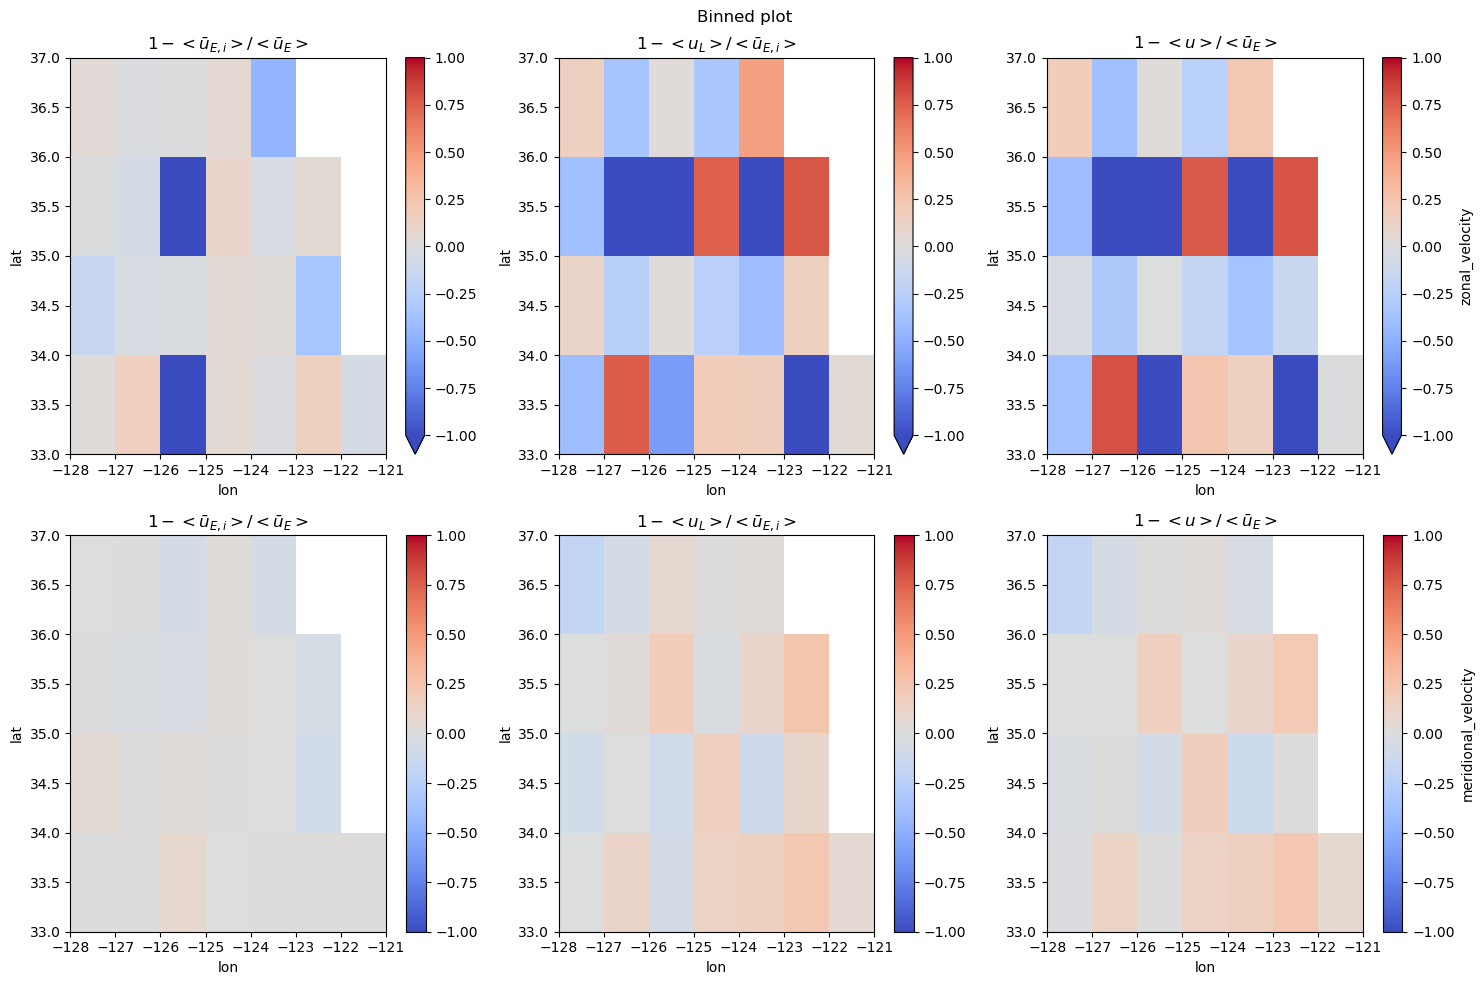

In [100]:
cmap='coolwarm'
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    (1-np.abs(dfL_mean[V+'_mean']/dfE_mean[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,0],vmax=1)
    (1-np.abs(dfL_mean[V]/dfL_mean[V+'_mean'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,1],vmax=1)
    (1-np.abs(dfL_mean[V]/dfE_mean[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,2],vmax=1)

    for title,ax in zip([r'$1-<\bar u_{E,i}>/<\bar u_E>$',r'$1-<u_L>/<\bar u_{E,i}>$',r'$1-<u>/<\bar u_E>$'],axs[i,:]):
        ax.set_title(title)

fig.suptitle('Binned plot')
fig.tight_layout()
#fig,ax = plt.subplots(1,3,figsize=(15,5))
#df_count.plot(y='lat',ax=ax[0])
#dfL_mean['count'].plot(y='lat',ax=ax[1])
#(dfL_mean['count']/df_count).plot(y='lat',ax=ax[2])
#fig.tight_layout()

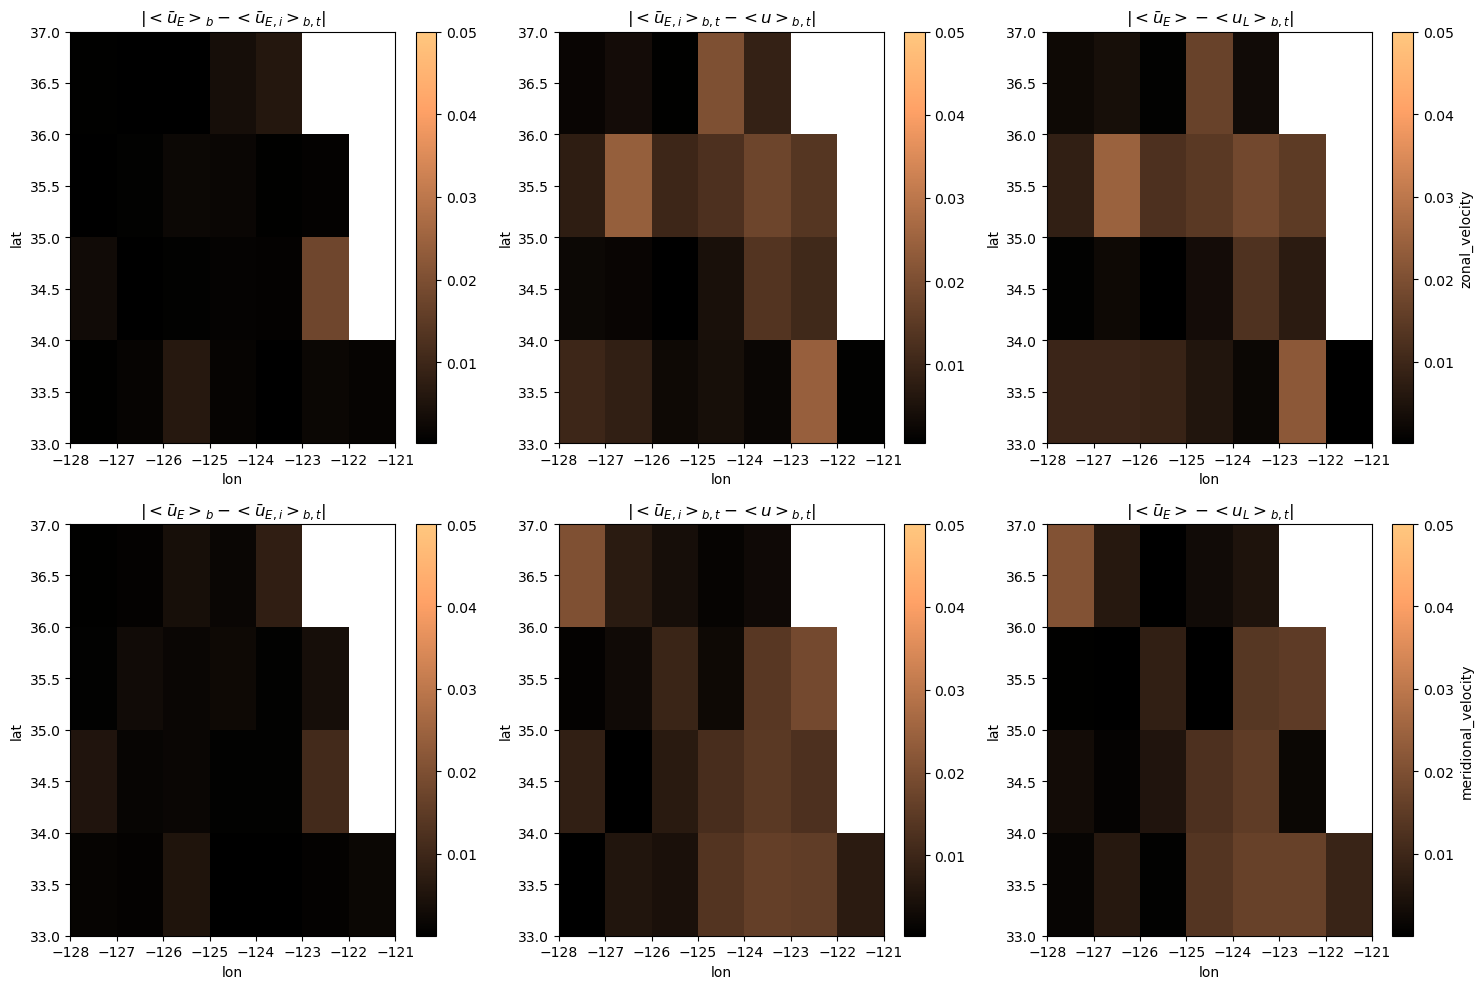

In [104]:
cmap='copper'
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    np.abs(dfE_mean[V]-dfL_mean[V+'_mean']).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,0],vmax=0.05)
    np.abs(dfL_mean[V+'_mean']-dfL_mean[V]).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,1],vmax=0.05)
    np.abs(dfE_mean[V]-dfL_mean[V]).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,2],vmax=0.05)

    for title,ax in zip([r'$\vert <\bar u_E>_b-<\bar u_{E,i}>_{b,t}\vert$',r'$\vert <\bar u_{E,i}>_{b,t}-<u>_{b,t}\vert$',r'$\vert<\bar u_E>-<u_L>_{b,t}\vert$'],axs[i,:]):
        ax.set_title(title)

fig.tight_layout()
#fig,ax = plt.subplots(1,3,figsize=(15,5))
#df_count.plot(y='lat',ax=ax[0])
#dfL_1dl['count'].plot(y='lat',ax=ax[1])
#dfL_1dl['count']/dfE_1dl['count']).plot(y='lat',ax=ax[2])
#fig.tight_layout()

### MKE

In [32]:
dfE_mean['MKE'] = dfE_mean['zonal_velocity']**2+dfE_mean['meridional_velocity']**2

dfL_mean['MKE_i'] = dfL_mean['zonal_velocity_mean']**2+dfL_mean['meridional_velocity_mean']**2
dfL_mean['MKE_b'] = dfL_mean['zonal_velocity']**2+dfL_mean['meridional_velocity']**2

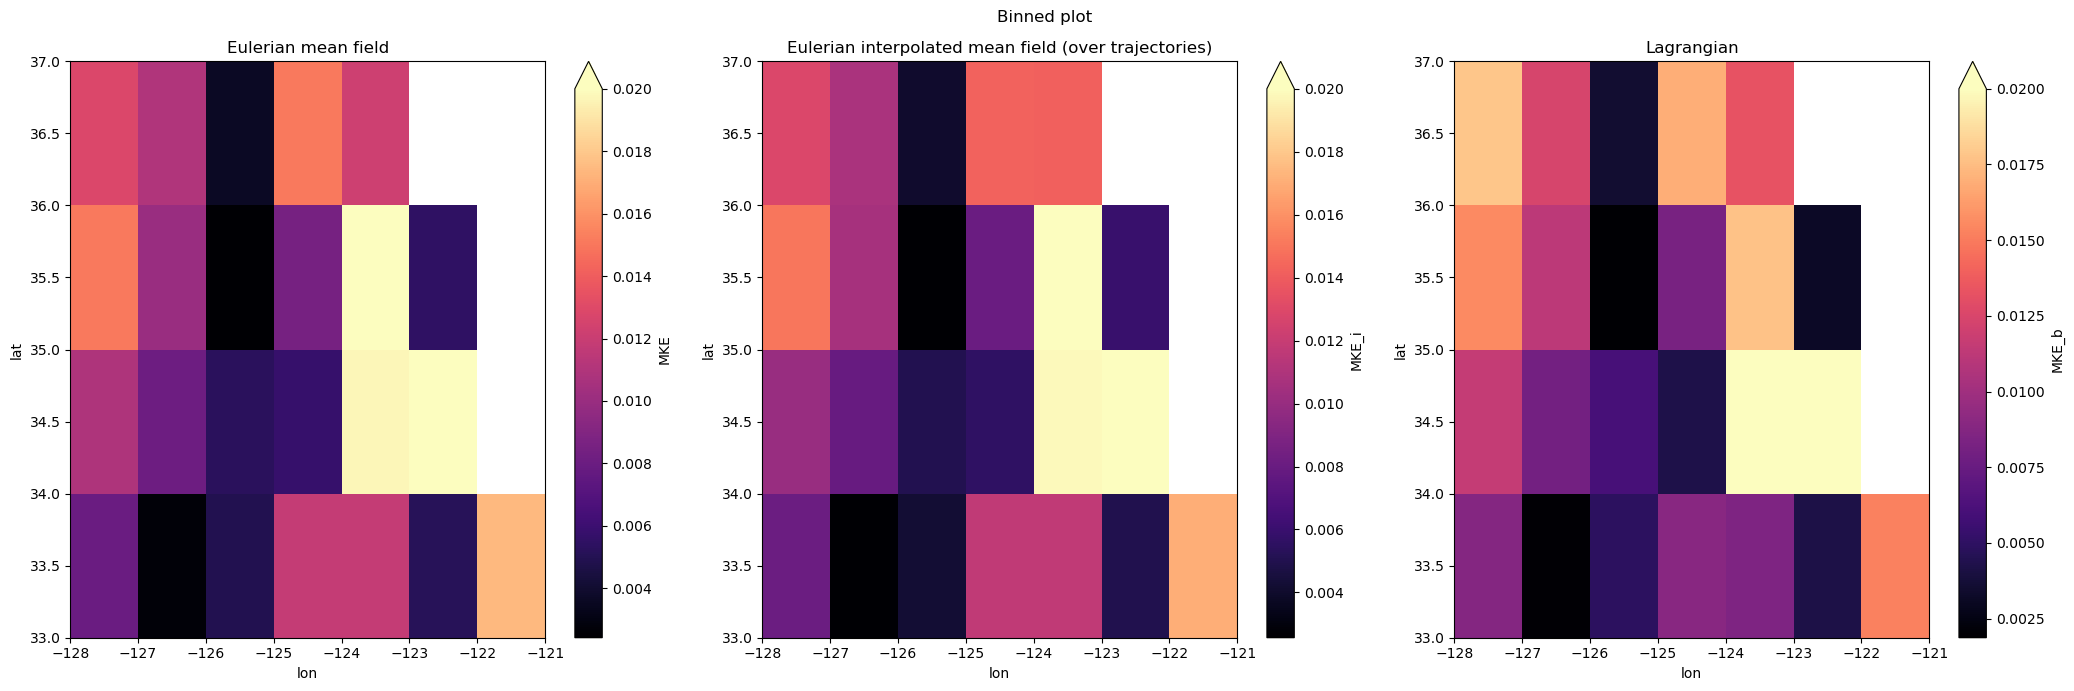

In [33]:
vmax=0.02
fig, axs = plt.subplots(1, 3, 
                           figsize=(21,7),
                          )

dfE_mean['MKE'].plot(x='lon',y='lat',cmap='magma',ax=axs[0],vmax=vmax)
dfL_mean['MKE_i'].plot(x='lon',y='lat',cmap='magma',ax=axs[1],vmax=vmax)
dfL_mean['MKE_b'].plot(x='lon',y='lat',cmap='magma',ax=axs[2],vmax=vmax)

for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs):
    ax.set_title(title)
fig.suptitle('Binned plot')
fig.tight_layout()

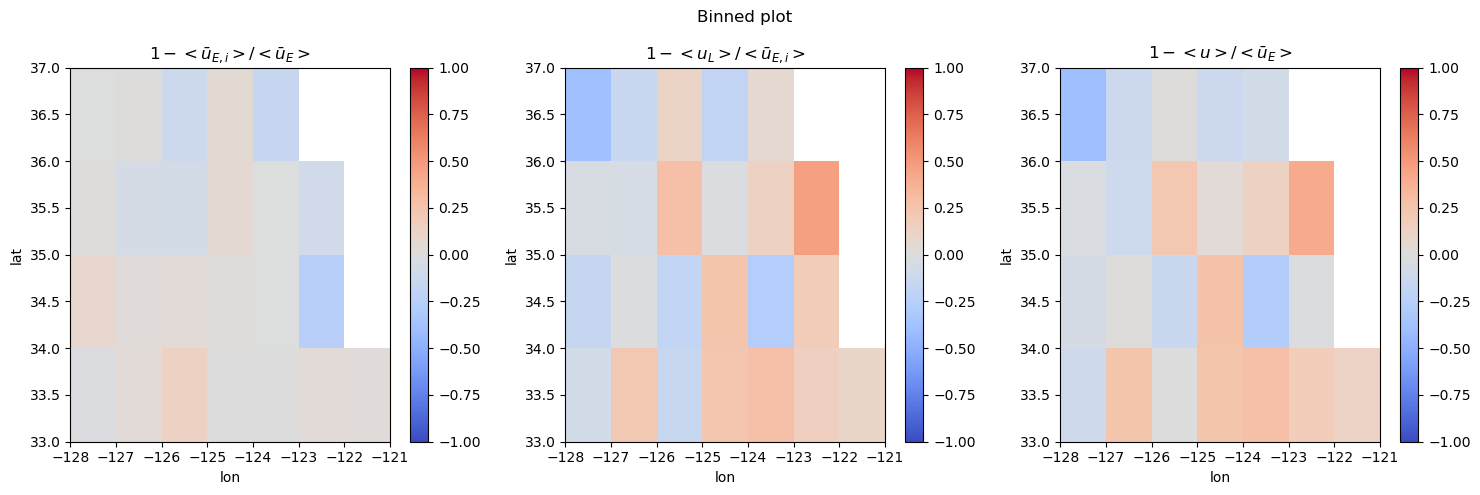

In [34]:
cmap='coolwarm'
fig, axs = plt.subplots(1,3,figsize=(15,5))
(1-np.abs(dfL_mean['MKE_i']/dfE_mean['MKE'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[0],vmax=1)
(1-np.abs(dfL_mean['MKE_b']/dfL_mean['MKE_i'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[1],vmax=1)
(1-np.abs(dfL_mean['MKE_b']/dfE_mean['MKE'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[2],vmax=1)

for title,ax in zip([r'$1-<\bar u_{E,i}>/<\bar u_E>$',r'$1-<u_L>/<\bar u_{E,i}>$',r'$1-<u>/<\bar u_E>$'],axs[:]):
    ax.set_title(title)

fig.suptitle('Binned plot')
fig.tight_layout()

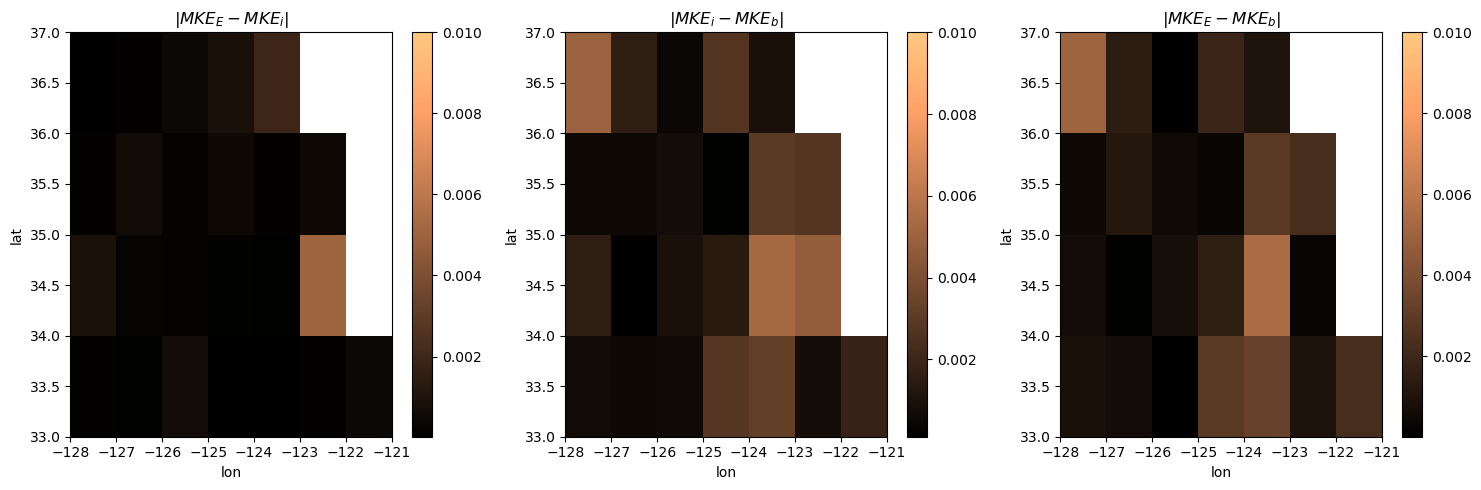

In [35]:
cmap='copper'
fig, axs = plt.subplots(1,3,figsize=(15,5))
np.abs(dfE_mean['MKE']-dfL_mean['MKE_i']).plot(x='lon',y='lat',cmap=cmap,ax=axs[0],vmax=0.01)
np.abs(dfL_mean['MKE_i']-dfL_mean['MKE_b']).plot(x='lon',y='lat',cmap=cmap,ax=axs[1],vmax=0.01)
np.abs(dfE_mean['MKE']-dfL_mean['MKE_b']).plot(x='lon',y='lat',cmap=cmap,ax=axs[2],vmax=0.01)

for title,ax in zip([r'$\vert MKE_E-MKE_i\vert$',r'$\vert MKE_i-MKE_b\vert$',r'$\vert MKE_E-MKE_b\vert$'],axs[:]):
    ax.set_title(title)

fig.tight_layout()

### Variance

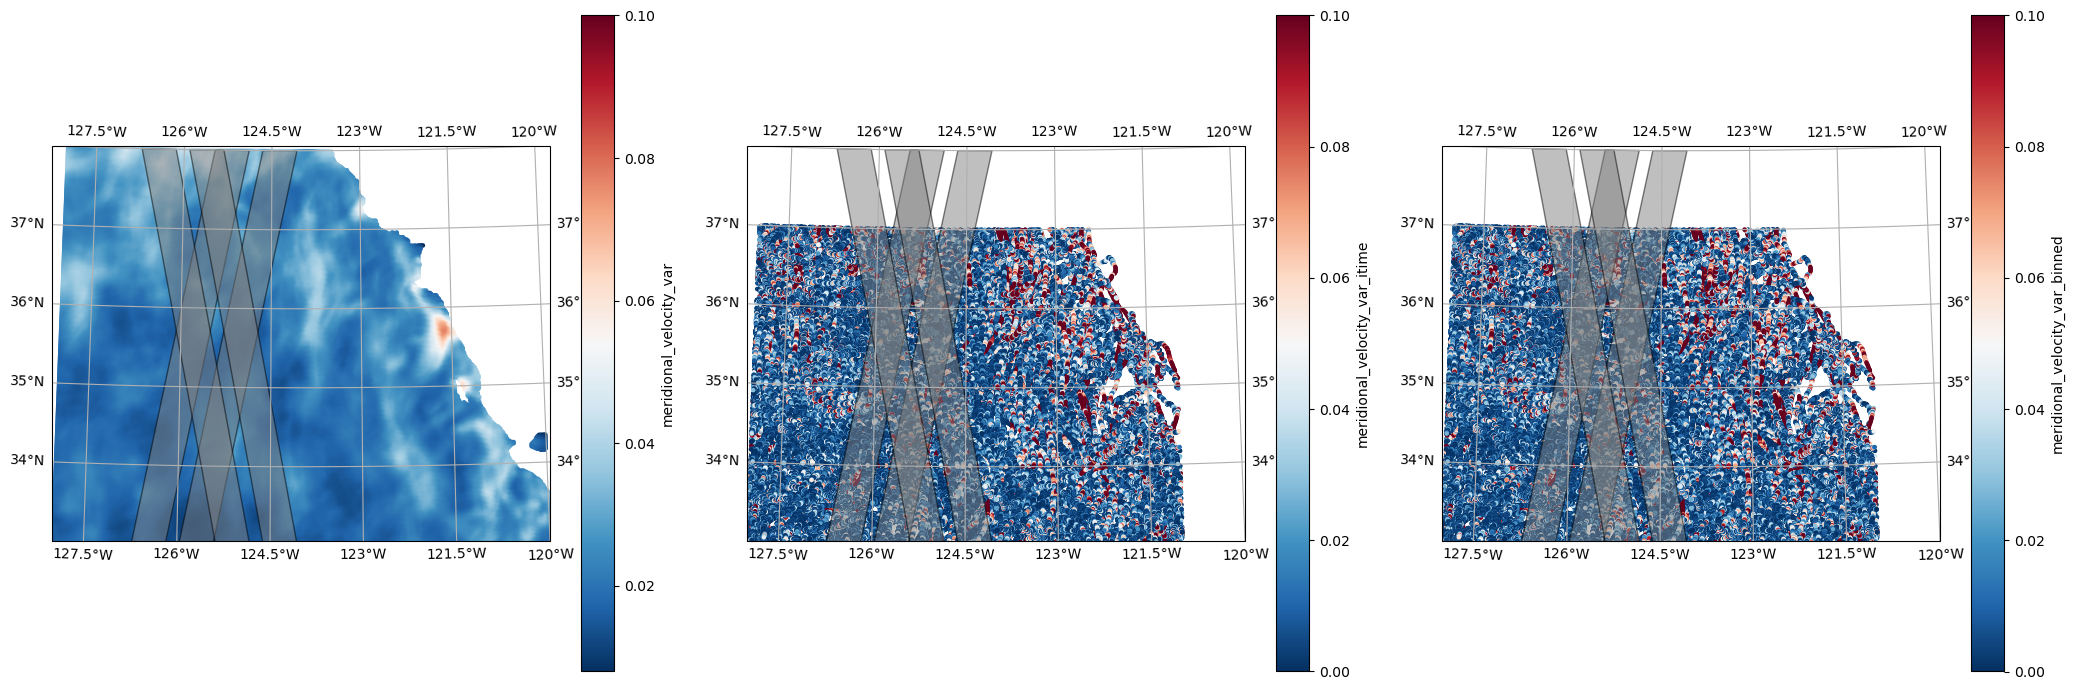

In [121]:
plot_swot([ds_mean.drop(['face']).to_dataframe(),df_merged,df_merged],
          ['meridional_velocity_var','meridional_velocity_var_itime','meridional_velocity_var_binned'],bbox,3,0.1,colmap,(21,7))

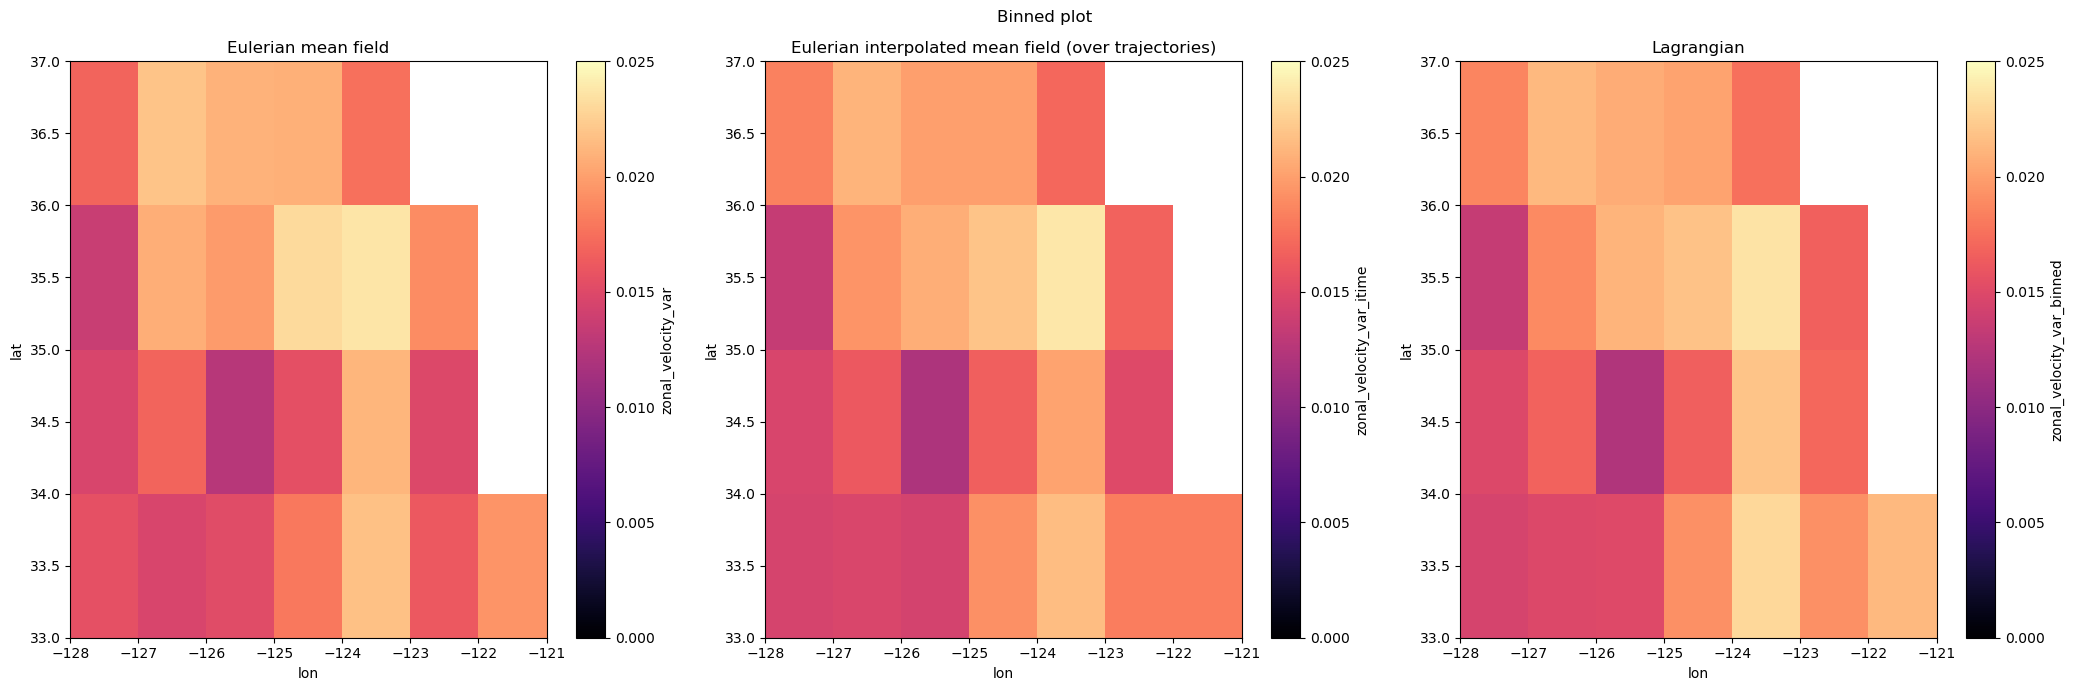

In [128]:
vmax=0.025
fig, axs = plt.subplots(1, 3, 
                           figsize=(21,7),
                          )

dfE_mean['zonal_velocity_var'].plot(x='lon',y='lat',cmap='magma',ax=axs[0],vmax=vmax,vmin=0)
dfL_mean['zonal_velocity_var_itime'].plot(x='lon',y='lat',cmap='magma',ax=axs[1],vmax=vmax,vmin=0)
dfL_mean['zonal_velocity_var_binned'].plot(x='lon',y='lat',cmap='magma',ax=axs[2],vmax=vmax,vmin=0)

for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs):
    ax.set_title(title)
fig.suptitle('Binned plot')
fig.tight_layout()

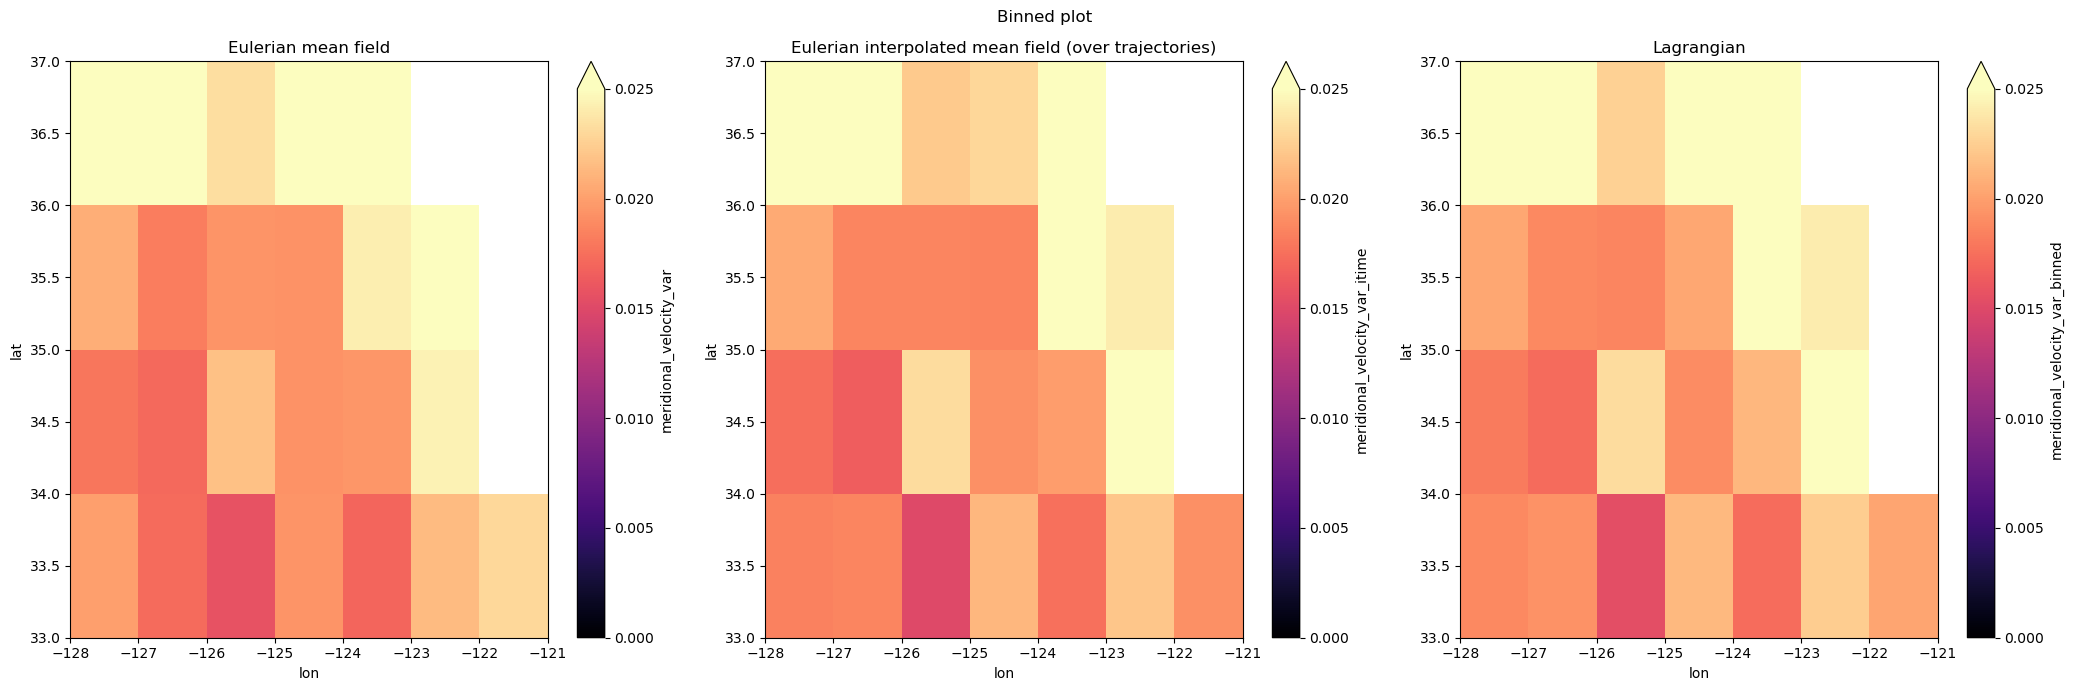

In [129]:
vmax=0.025
fig, axs = plt.subplots(1, 3, 
                           figsize=(21,7),
                          )

dfE_mean['meridional_velocity_var'].plot(x='lon',y='lat',cmap='magma',ax=axs[0],vmax=vmax,vmin=0)
dfL_mean['meridional_velocity_var_itime'].plot(x='lon',y='lat',cmap='magma',ax=axs[1],vmax=vmax,vmin=0)
dfL_mean['meridional_velocity_var_binned'].plot(x='lon',y='lat',cmap='magma',ax=axs[2],vmax=vmax,vmin=0)

for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs):
    ax.set_title(title)
fig.suptitle('Binned plot')
fig.tight_layout()

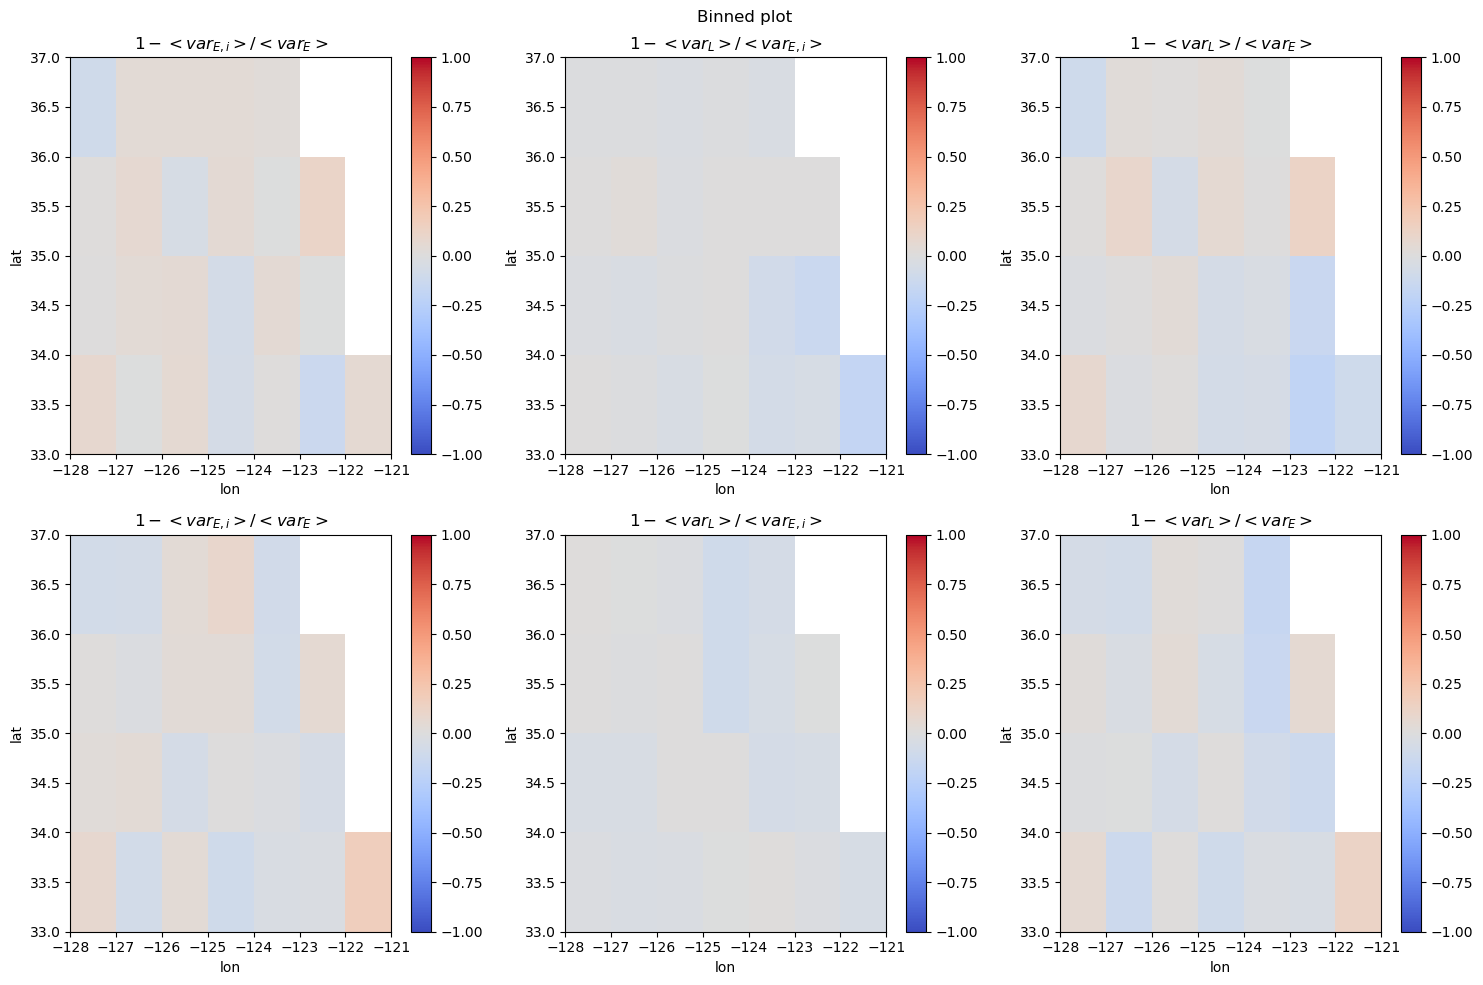

In [134]:
cmap='coolwarm'
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity_var','meridional_velocity_var']):
    (1-np.abs(dfL_mean[V+'_itime']/dfE_mean[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,0],vmax=1)
    (1-np.abs(dfL_mean[V+'_binned']/dfL_mean[V+'_itime'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,1],vmax=1)
    (1-np.abs(dfL_mean[V+'_binned']/dfE_mean[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,2],vmax=1)

    for title,ax in zip([r'$1-<var_{E,i}>/<var_E>$',r'$1-<var_L>/<var_{E,i}>$',r'$1-<var_L>/<var_E>$'],axs[i,:]):
        ax.set_title(title)

fig.suptitle('Binned plot')
fig.tight_layout()

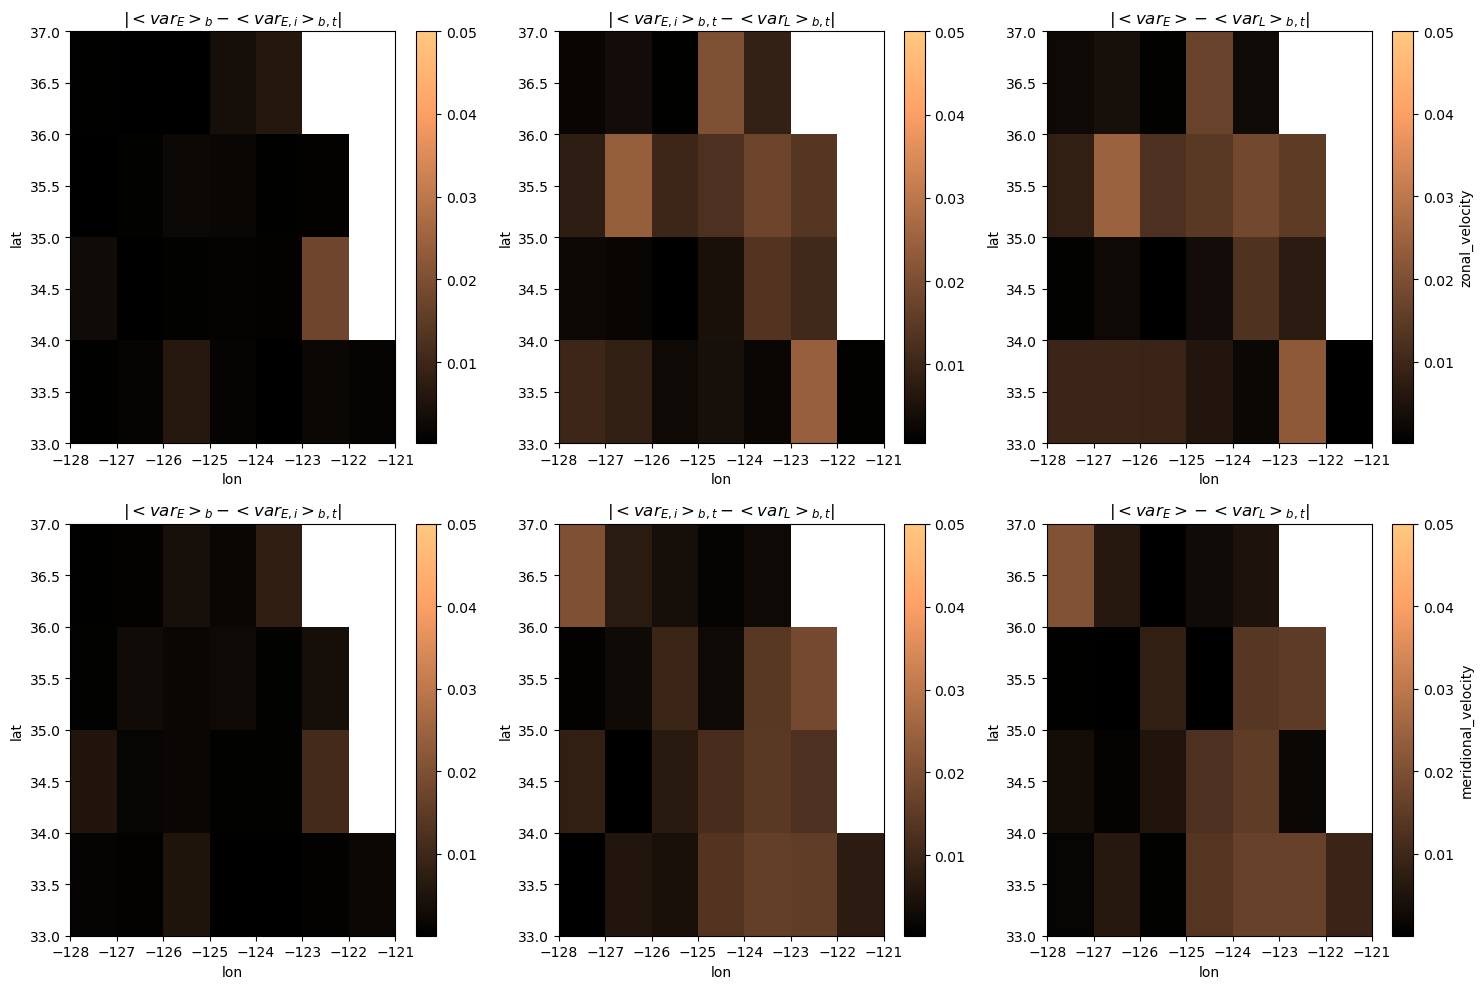

In [133]:
cmap='copper'
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    np.abs(dfE_mean[V]-dfL_mean[V+'_mean']).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,0],vmax=0.05)
    np.abs(dfL_mean[V+'_mean']-dfL_mean[V]).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,1],vmax=0.05)
    np.abs(dfE_mean[V]-dfL_mean[V]).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,2],vmax=0.05)

    for title,ax in zip([r'$\vert <var_E>_b-<var_{E,i}>_{b,t}\vert$',r'$\vert <var_{E,i}>_{b,t}-<var_L>_{b,t}\vert$',r'$\vert<var_E>-<var_L>_{b,t}\vert$'],axs[i,:]):
        ax.set_title(title)

fig.tight_layout()

### EKE

In [38]:
dfE_mean['EKE'] = dfE_mean['zonal_velocity_var']**2+dfE_mean['meridional_velocity_var']**2

dfL_mean['EKE_i'] = dfL_mean['zonal_velocity_var_itime']**2+dfL_mean['meridional_velocity_var_itime']**2
dfL_mean['EKE_b'] = dfL_mean['zonal_velocity_var_binned']**2+dfL_mean['meridional_velocity_var_binned']**2

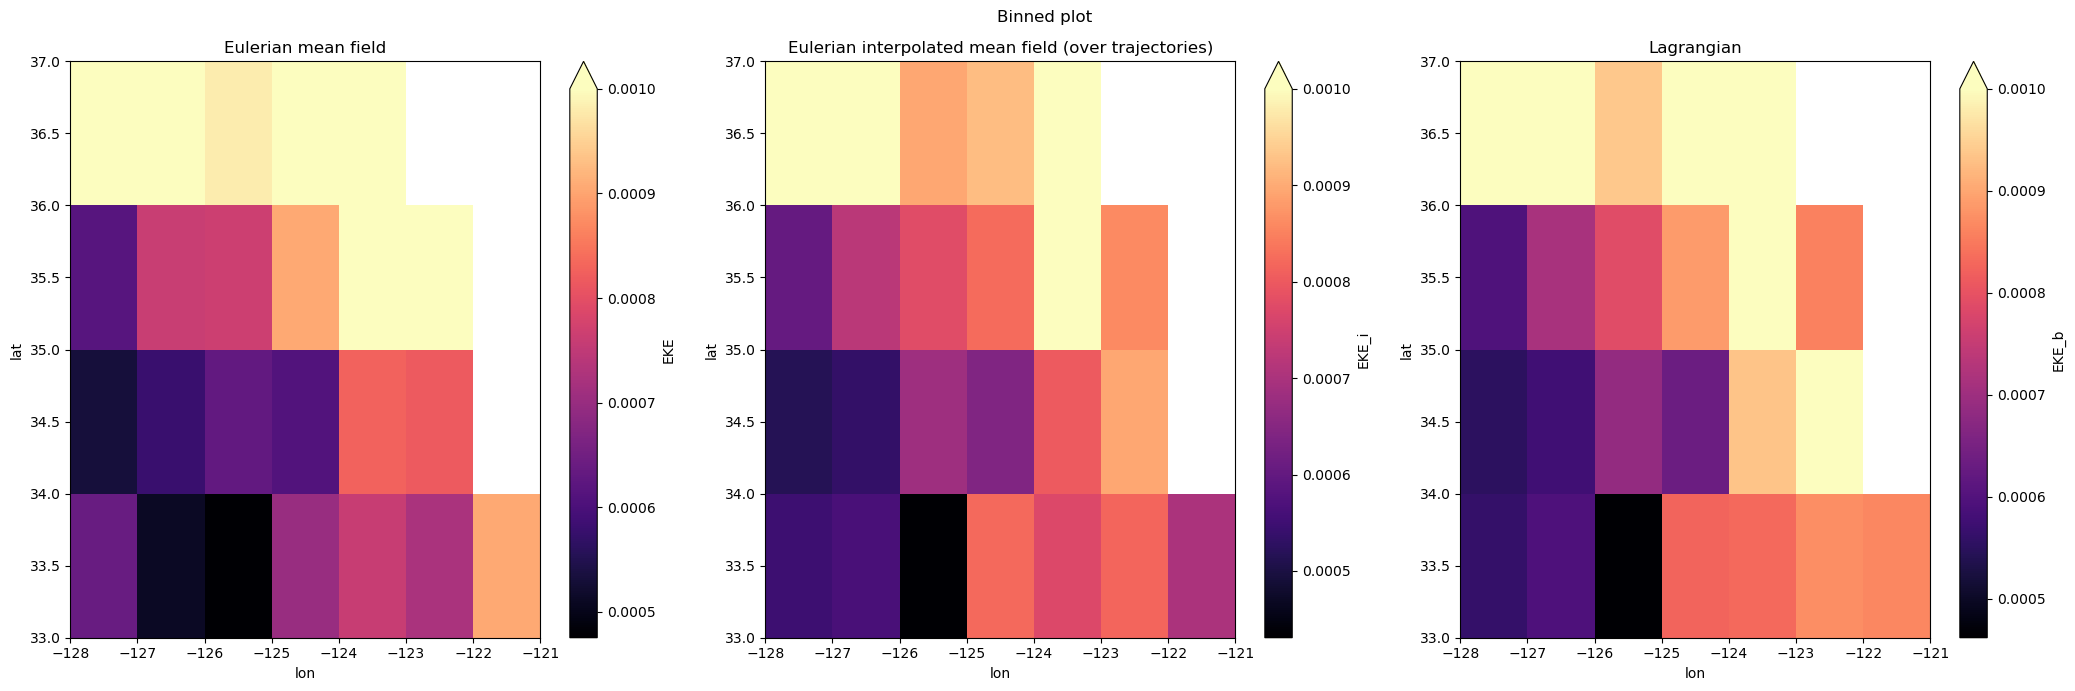

In [41]:
vmax=0.001
fig, axs = plt.subplots(1, 3, 
                           figsize=(21,7),
                          )

dfE_mean['EKE'].plot(x='lon',y='lat',cmap='magma',ax=axs[0],vmax=vmax)
dfL_mean['EKE_i'].plot(x='lon',y='lat',cmap='magma',ax=axs[1],vmax=vmax)
dfL_mean['EKE_b'].plot(x='lon',y='lat',cmap='magma',ax=axs[2],vmax=vmax)

for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs):
    ax.set_title(title)
fig.suptitle('Binned plot')
fig.tight_layout()

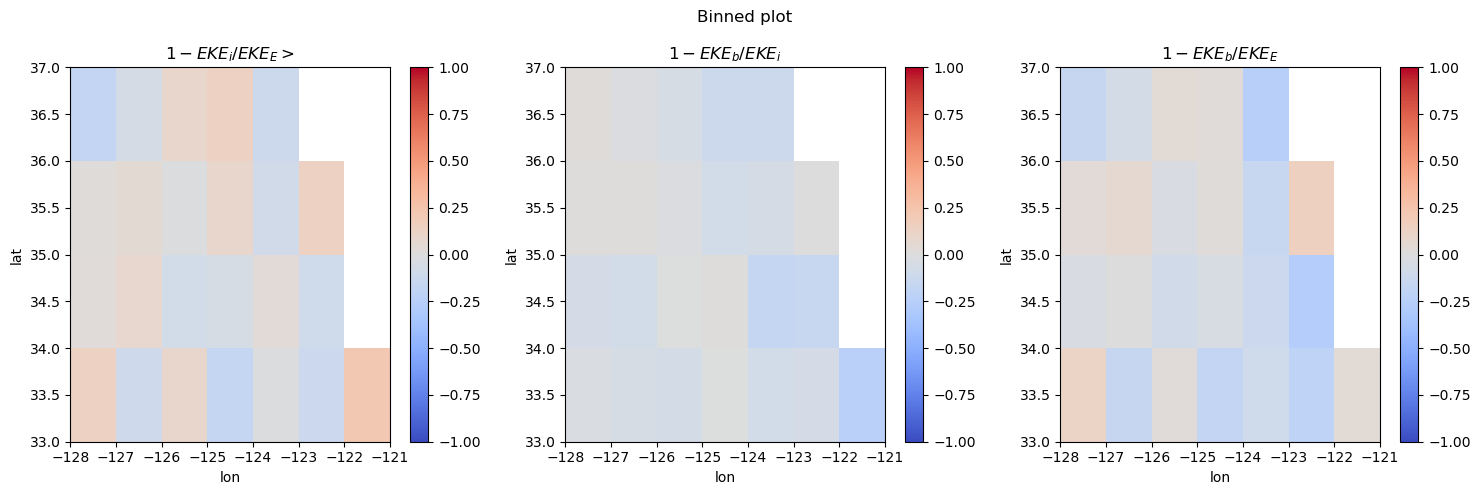

In [43]:
cmap='coolwarm'
fig, axs = plt.subplots(1,3,figsize=(15,5))
(1-np.abs(dfL_mean['EKE_i']/dfE_mean['EKE'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[0],vmax=1)
(1-np.abs(dfL_mean['EKE_b']/dfL_mean['EKE_i'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[1],vmax=1)
(1-np.abs(dfL_mean['EKE_b']/dfE_mean['EKE'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[2],vmax=1)

for title,ax in zip([r'$1-EKE_i/EKE_E>$',r'$1-EKE_b/EKE_i$',r'$1-EKE_b/EKE_E$'],axs[:]):
    ax.set_title(title)

fig.suptitle('Binned plot')
fig.tight_layout()

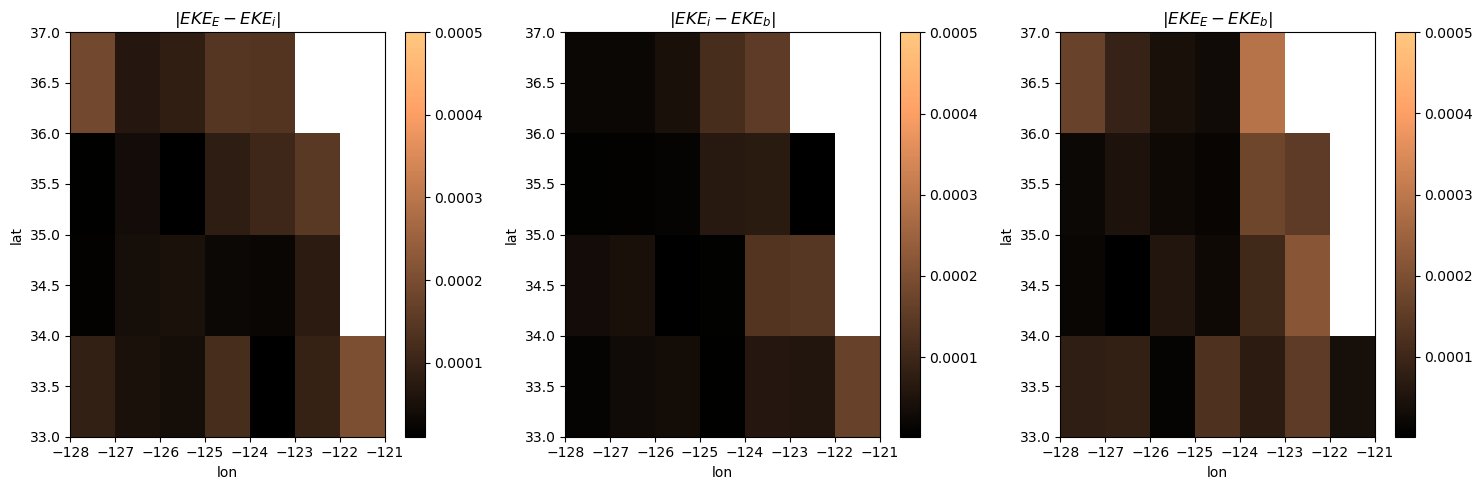

In [46]:
cmap='copper'
fig, axs = plt.subplots(1,3,figsize=(15,5))
np.abs(dfE_mean['EKE']-dfL_mean['EKE_i']).plot(x='lon',y='lat',cmap=cmap,ax=axs[0],vmax=0.0005)
np.abs(dfL_mean['EKE_i']-dfL_mean['EKE_b']).plot(x='lon',y='lat',cmap=cmap,ax=axs[1],vmax=0.0005)
np.abs(dfE_mean['EKE']-dfL_mean['EKE_b']).plot(x='lon',y='lat',cmap=cmap,ax=axs[2],vmax=0.0005)

for title,ax in zip([r'$\vert EKE_E-EKE_i\vert$',r'$\vert EKE_i-EKE_b\vert$',r'$\vert EKE_E-EKE_b\vert$'],axs[:]):
    ax.set_title(title)

fig.tight_layout()

### Differences : 
$<(u_L-\bar u_{E,i})**2>_{b,t}$

$<(u_L-<\bar u_{E,i}>_{b,t})**2>_{b,t}$

$<(u_L- <u_{L}>_{b,t})**2>_{b,t}$

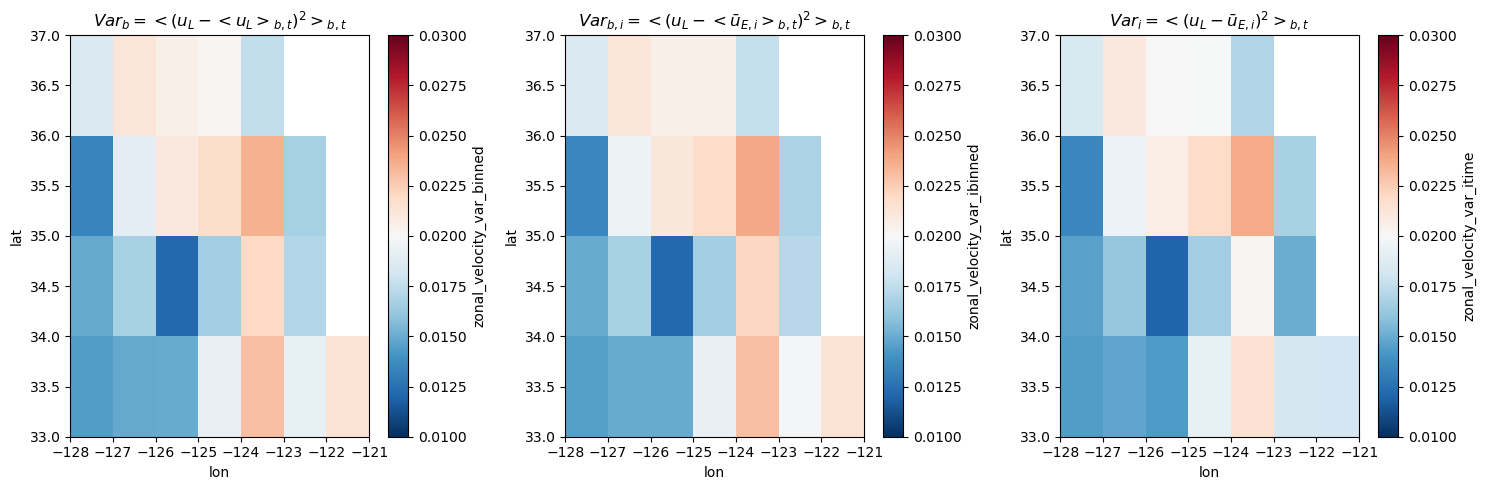

In [29]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for V,ax,title in zip(['binned','ibinned','itime'],axs,[r'$Var_b = <(u_L-<u_{L}>_{b,t})^2>_{b,t}$',r'$Var_{b,i} = <(u_L-<\bar u_{E,i}>_{b,t})^2>_{b,t}$',r'$Var_i = <(u_L-\bar u_{E,i})^2>_{b,t}$']):
    dfL_mean['zonal_velocity_var_'+V].plot(y='lat',cmap='RdBu_r',ax=ax,vmax=0.03,vmin=0.01)
    ax.set_title(title)
fig.tight_layout()

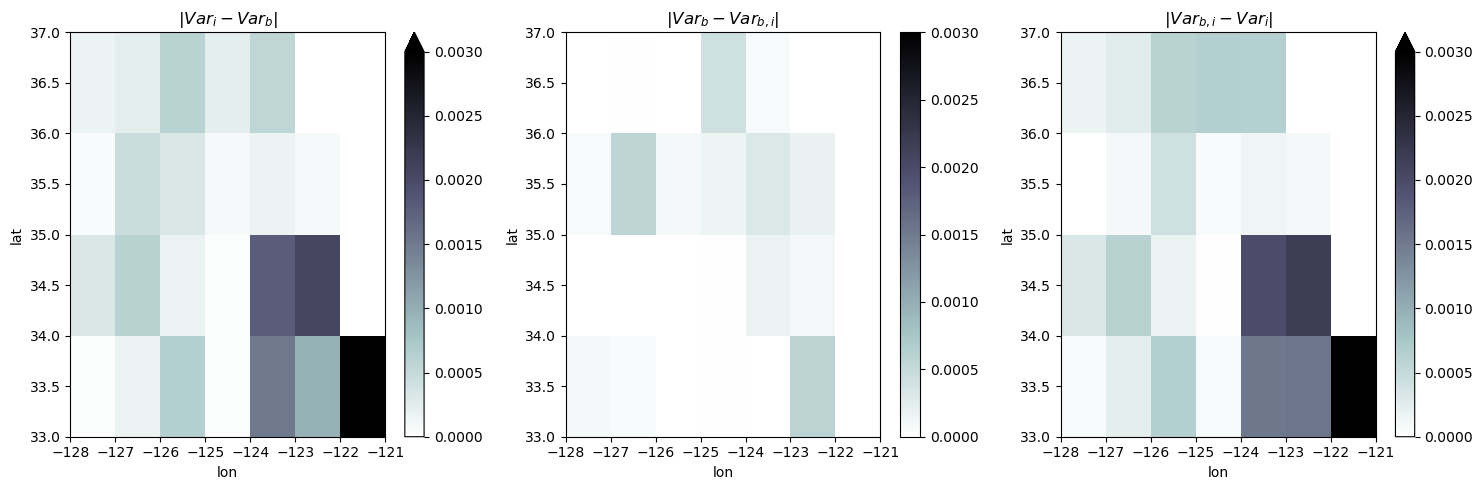

In [31]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
v = 'itime'
for V,ax,title in zip(['binned','ibinned','itime'],axs,[r'$\vert Var_i-Var_b\vert$',r'$\vert Var_b-Var_{b,i}\vert$',r'$\vert Var_{b,i}-Var_i\vert$']):
    np.abs(dfL_mean['zonal_velocity_var_'+v]-dfL_mean['zonal_velocity_var_'+V]).plot(y='lat',cmap='bone_r',ax=ax,vmin=0,vmax=0.003)
    ax.set_title(title)
    v=V
    
fig.tight_layout()

#### Notes : 
As expected the difference between varianc using binned and interpolated binned velocity is lower than the other differences

In [39]:
cluster.close()